# Wildfire predictions 🔥🌳🛰️🪄
# open in aws sagemaker lab

### 1. Install the first time (node, ipyleaflet)

In [ ]:
%conda info


     active environment : default
    active env location : /home/studio-lab-user/.conda/envs/default
            shell level : 2
       user config file : /home/studio-lab-user/.condarc
 populated config files : /etc/conda/.condarc
                          /opt/conda/.condarc
          conda version : 4.10.3
    conda-build version : not installed
         python version : 3.9.7.final.0
       virtual packages : __cuda=11.4=0
                          __linux=4.14.256=0
                          __glibc=2.31=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /opt/conda  (read only)
      conda av data dir : /opt/conda/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
          package cache : /home/studio-lab-user/.conda/pkgs
                          /opt/conda/pkgs
       envs directorie

In [ ]:
%pip list

Package                       Version
----------------------------- ------------
aenum                         3.1.8
affine                        2.3.0
aiobotocore                   2.1.0
aiohttp                       3.8.1
aioitertools                  0.8.0
aiosignal                     1.2.0
appdirs                       1.4.4
argon2-cffi                   21.1.0
asciitree                     0.3.3
async-generator               1.10
async-timeout                 4.0.2
attrs                         21.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
bleach                        4.1.0
boto3                         1.20.46
botocore                      1.23.48
bqplot                        0.12.32
branca                        0.4.2
certifi                       2021.10.8
cffi                          1.15.0
cftime                        1.5.2
charset-normalizer            2.0.10
click                         8.0.3
click-plugins                 1.1.1
cligj 

Check if **nodejs** is installed:

In [ ]:
!node --version

v17.4.0


Install nodejs if is no installed:

In [ ]:
%conda install -c conda-forge nodejs --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


**Restart kernel** in this step.

In [ ]:
%pwd

'/home/studio-lab-user'

In [ ]:
import sys
print(sys.path)

['/home/studio-lab-user', '/home/studio-lab-user/.conda/envs/default/lib/python39.zip', '/home/studio-lab-user/.conda/envs/default/lib/python3.9', '/home/studio-lab-user/.conda/envs/default/lib/python3.9/lib-dynload', '', '/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages', '/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/extensions', '/home/studio-lab-user/.ipython']


**IMPORTANT installation step**: 

Open the **terminal (not in jupyter notebook)** and activate the studiolab environment:

**$ conda activate studiolab**

Install the JupyterLab or Jupyter Server extension:

**$ conda install ipyleaflet**

Navigate to the Studio Lab project overview page (https://studiolab.sagemaker.aws/).

Select **Stop runtime**.

Select **Start runtime**.

### 2. Import modules and define constants

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from ipyleaflet import *
from ipywidgets import Label, HTML, DatePicker, Button, FileUpload
from ipywidgets import Image as ImageWidget
from IPython.display import Javascript
import datetime
from sentinelhub import SHConfig, bbox_to_dimensions, WebFeatureService, BBox, CRS, DataCollection, get_area_info, AwsTile, AwsTileRequest
import json

from base64 import b64encode
from PIL import Image, ImageSequence
from io import BytesIO

import rasterio
from rasterio import plot
import matplotlib
import matplotlib.pyplot as plt

import earthpy.spatial as es
import earthpy.plot as ep

In [ ]:
DATASET_FOLDER = './dl-fire-datasets'
DATASET_CROPPED_BEFORE_FIRE_FOLDER = './dataset_before_fire/'

M_C61_ARCHIVE = 'fire_archive_M-C61_246193.csv'
M_C61_NRT = 'fire_nrt_M-C61_246193.csv'

BBOX_SPAIN = [-9.494728, 35.418627, 3.290129, 44.133569]
LAT_LON_MADRID = [40.416775, -3.703790]

INITIAL_ZOOM = 6
ZOOM_SEARCH_FOUND = 10

DATE_START = datetime.date(2021,7,1)
DATE_END = datetime.date(2021,7,15)

DATE_START_STR = DATE_START.strftime("%Y-%m-%d")
DATE_END_STR = DATE_END.strftime("%Y-%m-%d")

IS_MARKER_CLUSTER_ACTIVE = True # activate or deactivate the marker clusters

In [ ]:
DATE_END_STR

'2021-07-15'

### 3. Load fire dataset and filter

Note: Check that the dataset (in CSV format) is in the DATASET_FOLDER folder. If it is in ZIP format, you must unzip it first.

In [ ]:
df_orig = pd.read_csv(os.path.join(DATASET_FOLDER, M_C61_ARCHIVE), sep=",", dtype={'acq_time': 'str'})

In [ ]:
df_orig

latitude  longitude  brightness  scan  track    acq_date acq_time  \
0        -11.2690   -27.6022       310.5   1.7    1.3  2021-01-01     0007   
1         -6.4528   143.2207       307.0   1.1    1.1  2021-01-01     0101   
2         28.7351     9.7986       303.2   1.0    1.0  2021-01-01     0119   
3         28.7368     9.7881       310.7   1.0    1.0  2021-01-01     0119   
4         31.5913     5.9692       302.2   1.2    1.1  2021-01-01     0119   
...           ...        ...         ...   ...    ...         ...      ...   
3090808  -32.6069   147.2451       306.6   1.5    1.2  2021-08-31     2357   
3090809  -32.1991   146.9268       304.8   1.6    1.2  2021-08-31     2357   
3090810  -32.6090   145.7355       304.1   1.8    1.3  2021-08-31     2357   
3090811  -32.1986   146.9203       312.9   1.6    1.2  2021-08-31     2357   
3090812  -38.1520   145.3238       304.3   1.5    1.2  2021-08-31     2358   

        satellite instrument  confidence  version  bright_t31   frp daynight  \
0           Terra      MODIS          71     6.03       294.7  16.4        N   
1           Terra      MODIS          50     6.03       292.4   5.0        D   
2            Aqua      MODIS          54     6.03       276.0  10.9        N   
3            Aqua      MODIS          81     6.03       276.8  16.1        N   
4            Aqua      MODIS          48     6.03       270.4  14.3        N   
...           ...        ...         ...      ...         ...   ...      ...   
3090808     Terra      MODIS          61     6.03       292.7  10.1        D   
3090809     Terra      MODIS          53     6.03       294.5   7.4        D   
3090810     Terra      MODIS          36     6.03       294.0   7.7        D   
3090811     Terra      MODIS          71     6.03       294.7  17.1        D   
3090812     Terra      MODIS          59     6.03       288.2   9.8        D   

         type  
0           3  
1           0  
2           2  
3           2  
4           2  
...       ...  
3090808     0  
3090809     0  
3090810     0  
3090811     0  
3090812     0  

[3090813 rows x 15 columns]

In [ ]:
df_orig.dtypes

latitude      float64
longitude     float64
brightness    float64
scan          float64
track         float64
acq_date       object
acq_time       object
satellite      object
instrument     object
confidence      int64
version       float64
bright_t31    float64
frp           float64
daynight       object
type            int64
dtype: object

In [ ]:
df_spain = df_orig[(df_orig.longitude > BBOX_SPAIN[0]) & (df_orig.longitude < BBOX_SPAIN[2]) & (df_orig.latitude > BBOX_SPAIN[1]) & (df_orig.latitude < BBOX_SPAIN[3])]
df_spain

latitude  longitude  brightness  scan  track    acq_date acq_time  \
3875      35.8061    -0.2536       310.2   3.9    1.8  2021-01-01     1359   
3876      35.7996    -0.2451       311.3   3.9    1.8  2021-01-01     1359   
4634      37.9583    -8.7866       301.0   2.5    1.5  2021-01-02     0200   
7322      37.0886    -5.8802       300.4   1.1    1.0  2021-01-02     1125   
7323      38.0170    -7.5735       300.0   1.0    1.0  2021-01-02     1125   
...           ...        ...         ...   ...    ...         ...      ...   
3069453   42.8734    -5.5579       302.3   1.1    1.0  2021-08-30     2227   
3069454   42.8750    -5.5446       327.0   1.1    1.0  2021-08-30     2227   
3069455   43.0303    -5.6210       342.0   1.1    1.0  2021-08-30     2227   
3069456   43.0319    -5.6081       339.4   1.1    1.0  2021-08-30     2227   
3086354   43.0295    -5.6183       332.1   1.5    1.2  2021-08-31     1348   

        satellite instrument  confidence  version  bright_t31   frp daynight  \
3875         Aqua      MODIS           0     6.03       282.0  92.3        D   
3876         Aqua      MODIS          34     6.03       280.1  98.3        D   
4634         Aqua      MODIS          36     6.03       276.8  33.1        N   
7322        Terra      MODIS          37     6.03       287.8   5.1        D   
7323        Terra      MODIS          21     6.03       283.0   6.1        D   
...           ...        ...         ...      ...         ...   ...      ...   
3069453     Terra      MODIS          48     6.03       284.5   7.5        N   
3069454     Terra      MODIS         100     6.03       286.6  30.7        N   
3069455     Terra      MODIS         100     6.03       284.5  54.9        N   
3069456     Terra      MODIS         100     6.03       284.5  50.1        N   
3086354      Aqua      MODIS          75     6.03       287.3  51.7        D   

         type  
3875        2  
3876        2  
4634        0  
7322        0  
7323        0  
...       ...  
3069453     0  
3069454     0  
3069455     0  
3069456     0  
3086354     0  

[3296 rows x 15 columns]

In [ ]:
df_spain = df_spain[df_spain['confidence'] > 70]
df_spain

latitude  longitude  brightness  scan  track    acq_date acq_time  \
10001     36.8745    -2.4347       334.7   1.2    1.1  2021-01-02     2228   
18725     40.2352    -0.8699       320.1   1.1    1.1  2021-01-04     1112   
24047     43.5413    -5.8322       317.1   1.0    1.0  2021-01-04     2218   
55101     40.9385    -8.0189       317.4   1.2    1.1  2021-01-07     1323   
55102     41.6448    -3.8641       315.8   1.0    1.0  2021-01-07     1324   
...           ...        ...         ...   ...    ...         ...      ...   
3069451   42.0482    -7.8604       309.5   1.0    1.0  2021-08-30     2227   
3069454   42.8750    -5.5446       327.0   1.1    1.0  2021-08-30     2227   
3069455   43.0303    -5.6210       342.0   1.1    1.0  2021-08-30     2227   
3069456   43.0319    -5.6081       339.4   1.1    1.0  2021-08-30     2227   
3086354   43.0295    -5.6183       332.1   1.5    1.2  2021-08-31     1348   

        satellite instrument  confidence  version  bright_t31   frp daynight  \
10001       Terra      MODIS         100     6.03       279.1  53.3        N   
18725       Terra      MODIS          80     6.03       276.0  26.4        D   
24047       Terra      MODIS          94     6.03       271.8  21.0        N   
55101        Aqua      MODIS          78     6.03       279.9  25.7        D   
55102        Aqua      MODIS          76     6.03       276.7  18.1        D   
...           ...        ...         ...      ...         ...   ...      ...   
3069451     Terra      MODIS          78     6.03       285.2  11.5        N   
3069454     Terra      MODIS         100     6.03       286.6  30.7        N   
3069455     Terra      MODIS         100     6.03       284.5  54.9        N   
3069456     Terra      MODIS         100     6.03       284.5  50.1        N   
3086354      Aqua      MODIS          75     6.03       287.3  51.7        D   

         type  
10001       2  
18725       0  
24047       2  
55101       0  
55102       0  
...       ...  
3069451     0  
3069454     0  
3069455     0  
3069456     0  
3086354     0  

[1581 rows x 15 columns]

In [ ]:
# Date range filter
df_spain_date_filtered = df_spain[(df_spain['acq_date'] >= DATE_START_STR) & (df_spain['acq_date'] <= DATE_END_STR)]
df_spain_date_filtered

latitude  longitude  brightness  scan  track    acq_date acq_time  \
1702958   35.9118     1.2323       337.2   1.9    1.3  2021-07-01     1239   
1706184   35.8067    -0.2533       319.6   1.0    1.0  2021-07-01     2201   
1721288   39.3638    -3.8653       334.0   2.1    1.4  2021-07-02     1141   
1724841   35.6441    -0.7811       345.8   1.1    1.0  2021-07-02     1322   
1724842   35.6426    -0.7928       337.0   1.1    1.0  2021-07-02     1322   
...           ...        ...         ...   ...    ...         ...      ...   
1970866   41.1895    -7.8678       323.4   3.7    1.8  2021-07-15     0325   
1970867   41.1954    -7.8570       319.8   3.7    1.8  2021-07-15     0325   
1982989   42.1290    -4.4215       322.9   1.9    1.3  2021-07-15     1253   
1987646   41.6589    -8.5126       313.8   1.3    1.1  2021-07-15     2215   
1987647   41.6780    -8.6348       314.8   1.3    1.1  2021-07-15     2215   

        satellite instrument  confidence  version  bright_t31    frp daynight  \
1702958      Aqua      MODIS          77     6.03       314.3   44.9        D   
1706184     Terra      MODIS          99     6.03       294.9   16.3        N   
1721288     Terra      MODIS          77     6.03       313.8   55.3        D   
1724841      Aqua      MODIS          87     6.03       315.6   37.0        D   
1724842      Aqua      MODIS          74     6.03       314.6   21.1        D   
...           ...        ...         ...      ...         ...    ...      ...   
1970866      Aqua      MODIS         100     6.03       287.2  152.3        N   
1970867      Aqua      MODIS          99     6.03       286.8  129.6        N   
1982989      Aqua      MODIS          73     6.03       306.0   24.4        D   
1987646     Terra      MODIS          88     6.03       294.6   16.8        N   
1987647     Terra      MODIS          90     6.03       294.4   17.9        N   

         type  
1702958     0  
1706184     2  
1721288     0  
1724841     0  
1724842     0  
...       ...  
1970866     0  
1970867     0  
1982989     0  
1987646     0  
1987647     0  

[86 rows x 15 columns]

### 4. Configure map and filters

In [ ]:
m = Map(center=LAT_LON_MADRID, zoom=INITIAL_ZOOM, basemap=basemaps.CartoDB.Voyager, layout=dict(height="700px"))

# fullscreen button
control = FullScreenControl()
m.add_control(control)

# distance
measure = MeasureControl(
    position="bottomleft", active_color="orange", primary_length_unit="kilometers"
)
m.add_control(measure)

# Search using url.
search = SearchControl(
    position="topleft",
    url="https://nominatim.openstreetmap.org/search?format=json&q={s}",
    zoom=ZOOM_SEARCH_FOUND,
    property_name="display_name",
    # marker=marker,
)
m.add_control(search)

# scale legend in km
scale = ScaleControl(position="bottomleft", imperial=False)
m.add_control(scale)

# label for lat/lon mouse position
labelLatLon = Label()
labelTotalFiresShow = Label()

global lastLatLonClicked
lastLatLonClicked = []

def handle_interaction(**kwargs):
    if kwargs.get("type") == "mousemove":
        labelLatLon.value = 'Mouse position (lat/Lon): ' + str(kwargs.get("coordinates"))
    elif kwargs.get("type") == "click":
        print('click')
        global lastLatLonClicked
        lastLatLonClicked = kwargs.get("coordinates")

m.on_interaction(handle_interaction)

In [ ]:
# Add markers
markers = []

the_markers_container = {}

if IS_MARKER_CLUSTER_ACTIVE == True:

    the_markers_container = MarkerCluster(
        markers=markers,
        disable_clustering_at_zoom=6,
        max_cluster_radius=50,
        show_coverage_on_hover=True,
        zoom_to_bounds_on_click=True,
        spiderfy_on_max_zoom=True
    )
    the_markers_container.name = "THE FIRES (clusters active)"

else:
    the_markers_container = LayerGroup(layers=(markers), name='THE FIRES')

m.add_layer(the_markers_container)

m.add_control(LayersControl())

In [ ]:
def get_color(row):
    """
    Types of fires:
    0 = presumed vegetation fire
    1 = active volcano
    2 = other static land source
    3 = offshore detection (includes all detections over water)
    
    Supported colors:
    ['white', 'red', 'darkred', 'lightred', 'orange', 'beige', 'green', 
    'darkgreen', 'lightgreen', 'blue', 'darkblue', 'lightblue', 'purple',
    'darkpurple', 'pink', 'cadetblue', 'white', 'gray', 'lightgray', 'black']
    """
    if 'type' not in row:
        return 'black'
    
    v = row['type']
    if v==0:
        return 'green'
    elif v==1:
        return 'orange'
    elif v==2:
        return 'gray'
    elif v==3:
        return 'blue'
    else:
        return 'black'

def get_type_name(row):
    if 'type' not in row:
        return 'fire type not available'
    
    v = row['type']
    if v==0:
        return 'presumed vegetation fire'
    elif v==1:
        return 'active volcano'
    elif v==2:
        return 'other static land source'
    elif v==3:
        return 'offshore detection (includes all detections over water)'
    else:
        return 'unknown fire type'

# latitude	longitude	brightness	scan	track	acq_date	acq_time...
# ...satellite	instrument	confidence	version	bright_t31	frp	daynight
def create_popup_marker(row, index):
    html_widget = HTML(
        value="""
            <div>
            <b>{t}</b><br/>
            Lat/Lon: {lat}, {lon}<br/>
            acq_date: {acq_date}<br/>
            acq_time: {acq_time} (hh:mm UTC)<br/>
            confidence: {confidence} %<br/>
            FRP: {frp}<br/>
            index: {index}
            </div>
            """.format(t=get_type_name(row), lat=row.latitude, lon=row.longitude, acq_date=row.acq_date,
                             acq_time=row.acq_time, confidence=row.confidence, frp=row.frp, index=index),
        placeholder="",
        description="",
    )
    return html_widget

In [ ]:
def update_date_filter_and_markers(df_full, date_from, date_to):
    df_filtered = df_full[(df_full['acq_date'] >= date_from) & (df_full['acq_date'] <= date_to)]
    
    markers = []
    
    for index, row in df_filtered.iterrows(): 
        icon = AwesomeIcon(name='fire', marker_color=get_color(row))
        marker_aux = Marker(icon=icon, location=(row['latitude'], row['longitude']))
        marker_aux.popup = create_popup_marker(row, index)
        markers.append(marker_aux)
    return df_filtered, markers

In [ ]:
df_spain_date_filtered, markers = update_date_filter_and_markers(df_spain, DATE_START_STR, DATE_END_STR)

In [ ]:
len(markers)

86

In [ ]:
if IS_MARKER_CLUSTER_ACTIVE == True:
    the_markers_container.markers = markers
else:
    the_markers_container.layers = markers

In [ ]:
# legend
a_legend = LegendControl(
    {
        "🌳 Presumed vegetation fire": "green",
        "🌋 Active volcano": "orange",
        "🏢 Other static land source": "gray",
        "🌊 Offshore detection (includes all detections over water)": "blue",
        "❓ Unknown type": 'black'
    },
    name="Legend",
    position="bottomright",
)

m.add_control(a_legend)

In [ ]:
def map_bounds_changed(event):
    # TODO: I can filter by bound when bound changed
    print('map_bounds_changed')
    # print(str(event))

In [ ]:
fromDate = DatePicker(
    description='From',
    disabled=False
)
fromDate.value= DATE_START

toDate = DatePicker(
    description='To',
    disabled=False
)
toDate.value= DATE_END

btnFilter = Button(
    description=' Filter ',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='filter' # (FontAwesome names without the `fa-` prefix)
)


controlFrom = WidgetControl(widget=fromDate, position="topright")
m.add_control(controlFrom)

controlTo = WidgetControl(widget=toDate, position="topright")
m.add_control(controlTo)

controlButton = WidgetControl(widget=btnFilter, position="topright")
m.add_control(controlButton)

m.observe(map_bounds_changed, 'bounds')

In [ ]:
def date_filter_handler(button):
    m.default_style = {"cursor": "wait"}
    btnFilter.description = 'Filtering...'
    
    from_date_str = fromDate.value.strftime("%Y-%m-%d")
    to_date_str = toDate.value.strftime("%Y-%m-%d")
    
    df_spain_date_filtered, markers = update_date_filter_and_markers(df_spain, from_date_str, to_date_str)
    

    if IS_MARKER_CLUSTER_ACTIVE == True:
        the_markers_container.markers = markers
    else:
        the_markers_container.layers = markers
    
    
    labelTotalFiresShow.value = str(len(markers)) + ' fires shown'
    
    m.default_style = {"cursor": "default"}
    
    btnFilter.description = 'Filtered (' + str(len(markers)) + ' fires)'

In [ ]:
btnFilter.on_click(date_filter_handler)

### 5. Show the map

In [ ]:
display(m)
display(labelLatLon)
display(labelTotalFiresShow)

Map(center=[40.416775, -3.70379], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

Label(value='')

Label(value='')

### 6. Download satellite images from before the fire started and after the fire started.

In [ ]:
selected_row = df_orig.iloc[1987646] # 1843754] # select one fire by index row.

In [ ]:
"""
index: 1843754
presumed vegetation fire
Lat/Lon: 39.7322, -5.436
acq_date: 2021-07-08
acq_time: 12:46 (hh:mm UTC)
confidence: 100 %
FRP: 1022.3
"""

def get_search_time_interval_and_lat_lon(r):
    lat_lon = [r['latitude'], r['longitude']]
    fire_selected_date_str = r['acq_date'] # fire date
    split_date = fire_selected_date_str.split('-')

    fire_selected_date = datetime.date(int(split_date[0]),int(split_date[1]),int(split_date[2]))
    print(fire_selected_date)

    datetime_from = fire_selected_date - datetime.timedelta(days=15) # -15 days before fire.
    datetime_from_str = datetime_from.strftime("%Y-%m-%d") + 'T00:00:00'

    datetime_to = fire_selected_date + datetime.timedelta(days=5) # +5 days after fire begun.
    datetime_to_str = datetime_to.strftime("%Y-%m-%d") + 'T00:00:00'

    search_time_interval = (datetime_from_str, datetime_to_str)
    
    print('search_time_interval: ' + str(search_time_interval))
    
    return search_time_interval, lat_lon

In [ ]:
search_time_interval, lat_lon = get_search_time_interval_and_lat_lon(selected_row)
search_time_interval

2021-07-15
search_time_interval: ('2021-06-30T00:00:00', '2021-07-20T00:00:00')


('2021-06-30T00:00:00', '2021-07-20T00:00:00')

In [ ]:
config = SHConfig()

with open("config.json") as json_data_file:
    cfg = json.load(json_data_file)

config.instance_id = cfg["sentinelhub"]["instance_id"]
config.aws_access_key_id = cfg["aws"]["access_key_id"]
config.aws_secret_access_key = cfg["aws"]["secret_access_key"]

# Save the configuration
config.save()

In [ ]:
def get_search_bbox(lat_lon):
    offset = 0.0044991155958
    x = lat_lon[1]
    y = lat_lon[0]
    one_fire_box = [x-offset, y-offset, x+offset, y+offset]
    # print(one_fire_box)

    search_bbox = BBox(bbox=one_fire_box, crs=CRS.WGS84)
    return search_bbox

In [ ]:
search_bbox = get_search_bbox(lat_lon)
search_bbox

BBox(((-8.517099115595801, 41.654400884404204), (-8.5081008844042, 41.6633991155958)), crs=CRS('4326'))

In [ ]:
def get_data_before_and_after_one_fire(search_bbox, search_time_interval):
    results = get_area_info(search_bbox, search_time_interval, maxcc=0.5)
    print(str(len(results)) + ' satellite moments in the interval:\n')

    tile_id_before_fire = ''
    tile_id_after_fire = ''

    tile_name= ''

    bound_tile = []

    for tile_info in results: # maxcc in range [0, 1] – filter imgs by max % of clouds.
        if 'VGS2' not in tile_id_after_fire:
            tile_id_after_fire = tile_info['properties']['title'] 
            tile_name = tile_id_after_fire.split('_')[-2]
            bound_tile = tile_info['geometry']['coordinates'][0][0]
        elif 'VGS2' in tile_info['properties']['title']:
            if tile_name in tile_info['properties']['title']:
                tile_id_before_fire = tile_info['properties']['title'] 

        suffix = ''
        title = tile_info['properties']['title']

        print(title + suffix)
        print('  ' + str(tile_info['geometry']['coordinates']))
    
    return tile_id_before_fire, tile_id_after_fire, bound_tile

In [ ]:
tile_id_before_fire, tile_id_after_fire, bound_tile = get_data_before_and_after_one_fire(search_bbox, search_time_interval)

6 satellite moments in the interval:

S2B_OPER_MSI_L1C_TL_VGS4_20210718T121443_A022800_T29TNG_N03.01
  [[[[-8.8423471015163, 42.45257377694], [-9.0002292584089, 41.955024562881], [-9.0002275196194, 41.463760893976], [-7.6855936689808, 41.4562510388], [-7.6651207807638, 42.444908861831], [-8.8423471015163, 42.45257377694]]]]
S2A_OPER_MSI_L1C_TL_VGS2_20210716T134648_A031680_T29TNG_N03.01
  [[[[-9.0002310646851, 42.452682192651], [-9.0002275196194, 41.463760893976], [-8.0289670073484, 41.459662384459], [-7.8835149624185, 41.856765788792], [-7.6810608452733, 42.389965447631], [-7.6671786674308, 42.42229648066], [-7.6663366605707, 42.444923017239], [-9.0002310646851, 42.452682192651]]]]
S2A_OPER_MSI_L1C_TL_VGS2_20210713T133315_A031637_T29TNG_N03.01
  [[[[-8.8352936452366, 42.452563858763], [-9.0002291771032, 41.932324189439], [-9.0002275196194, 41.463760893976], [-7.6855936689808, 41.4562510388], [-7.6651207807638, 42.444908861831], [-8.8352936452366, 42.452563858763]]]]
S2B_OPER_MSI_L1C_TL

In [ ]:
print(tile_id_before_fire) # = results[0]['properties']['title']
print(tile_id_after_fire) # = results[-1]['properties']['title']

S2A_OPER_MSI_L1C_TL_VGS2_20210713T133315_A031637_T29TNG_N03.01
S2A_OPER_MSI_L1C_TL_VGS2_20210716T134648_A031680_T29TNG_N03.01


In [ ]:
bound_tile

[[-9.0002310646851, 42.452682192651],
 [-9.0002275196194, 41.463760893976],
 [-8.0289670073484, 41.459662384459],
 [-7.8835149624185, 41.856765788792],
 [-7.6810608452733, 42.389965447631],
 [-7.6671786674308, 42.42229648066],
 [-7.6663366605707, 42.444923017239],
 [-9.0002310646851, 42.452682192651]]

In [ ]:
# manual version:
# tile_id_before_fire = 'S2B_OPER_MSI_L1C_TL_VGS2_20210705T131926_A022614_T29TQE_N03.01'
# tile_id_after_fire = 'S2A_OPER_MSI_L1C_TL_VGS2_20210710T132405_A031594_T29TQE_N03.01'

In [ ]:
tile_name_before, time_before, aws_index_before = AwsTile.tile_id_to_tile(tile_id_before_fire)
tile_name_after, time_after, aws_index_after = AwsTile.tile_id_to_tile(tile_id_after_fire)
tile_name_after, time_after, aws_index_after

('29TNG', '2021-7-16', 0)

In [ ]:
def request_tiles(tile_name_before, time_before, aws_index_before, tile_name_after, time_after, aws_index_after):
    bands = ['B02'] # , 'B03', 'B04', 'B08']
    metafiles = ['metadata', 'tileInfo', 'preview', 'qi/MSK_CLOUDS_B00'] # ['metadata', 'tileInfo', 'preview/B01', 'TCI']
    data_folder = './AwsData'
    
    request = AwsTileRequest(
        tile=tile_name_before,
        time=time_before,
        aws_index=aws_index_before,
        bands=bands,
        metafiles=metafiles,
        data_folder=data_folder,
        data_collection=DataCollection.SENTINEL2_L1C
    )

    request.save_data()
    
    FOLDER_BEFORE = './AwsData/{}/'.format(request.get_filename_list()[0].split('/')[0])
    print('FOLDER_BEFORE: ' + FOLDER_BEFORE)
    
    request = AwsTileRequest(
        tile=tile_name_after,
        time=time_after,
        aws_index=aws_index_after,
        bands=bands,
        metafiles=metafiles,
        data_folder=data_folder,
        data_collection=DataCollection.SENTINEL2_L1C
    )

    request.save_data()
    
    FOLDER_AFTER = './AwsData/{}/'.format(request.get_filename_list()[0].split('/')[0])
    print('FOLDER_AFTER: ' + FOLDER_AFTER)
    
    return FOLDER_BEFORE, FOLDER_AFTER

In [ ]:
FOLDER_BEFORE, FOLDER_AFTER = request_tiles(tile_name_before, time_before, aws_index_before, tile_name_after, time_after, aws_index_after)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.01 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)


FOLDER_BEFORE: ./AwsData/29TNG,2021-07-13,0/
FOLDER_AFTER: ./AwsData/29TNG,2021-07-16,0/


### 7. Calculate fire rectangle perimeter (in order tu crop images)

In [ ]:
def swap_lat_lon(v):
    bound_tile_new = []
    for one in v:
        bound_tile_new.append([one[1], one[0]])
    return bound_tile_new

In [ ]:
fire_small_perimeter = swap_lat_lon(search_bbox.get_polygon())
fire_small_perimeter

[[41.654400884404204, -8.517099115595801],
 [41.6633991155958, -8.517099115595801],
 [41.6633991155958, -8.5081008844042],
 [41.654400884404204, -8.5081008844042],
 [41.654400884404204, -8.517099115595801]]

In [ ]:
# bound_tile = results[-1]['geometry']['coordinates'][0][0]
"""
[[-6.5454514550479, 40.596392838306], 
              [-6.4945014949822, 39.609022489798], 
              [-5.2167765905168, 39.640457343317], 
              [-5.2491462940419, 40.628939760926], 
              [-6.5454514550479, 40.596392838306]]
"""
bound_tile = swap_lat_lon(bound_tile)

### 8. Overlay image previews in map (image before fire and image after fire)

In [ ]:
pl = Polyline(locations=bound_tile, name='Tile perimeter')
m.add_layer(pl)
print(bound_tile)

[[42.452682192651, -9.0002310646851], [41.463760893976, -9.0002275196194], [41.459662384459, -8.0289670073484], [41.856765788792, -7.8835149624185], [42.389965447631, -7.6810608452733], [42.42229648066, -7.6671786674308], [42.444923017239, -7.6663366605707], [42.452682192651, -9.0002310646851]]


In [ ]:
pl_fire = Polyline(locations=fire_small_perimeter, color='red', fill_opacity=0, name='Fire small perimeter')
m.add_layer(pl_fire)

In [ ]:
# m.remove_layer(pl_fire)

In [ ]:
def image_overlay(map, url, bounds, name):
        """Overlays an image from the Internet or locally on the map.

        Args:
            url (str): http URL or local file path to the image.
            bounds (tuple): bounding box of the image in the format of (lower_left(lat, lon), upper_right(lat, lon)), such as ((13, -130), (32, -100)).
            name (str): name of the layer to show on the layer control.
        """
        try:
            if not url.startswith('http'):
                ext = os.path.splitext(url)[1][1:] # file extension
                image = Image.open(url)

                f = BytesIO()
                if ext.lower() == 'gif':
                    frames = []
                    # Loop over each frame in the animated image
                    for frame in ImageSequence.Iterator(image):
                        frame = frame.convert('RGBA')
                        b = BytesIO()
                        frame.save(b, format="gif")
                        frame = Image.open(b)
                        frames.append(frame)
                    frames[0].save(f, format='GIF', save_all=True, append_images=frames[1:], loop=0)
                else:                 
                    image.save(f, 'png') # ext)

                data = b64encode(f.getvalue())
                data = data.decode('ascii')
                url = 'data:image/{};base64,'.format(ext) + data
            img = ImageOverlay(url=url, bounds=bounds, name=name)
            map.add_layer(img)
            return img
        except Exception as e:
            print(e)
            return

In [ ]:
aux_layer_before = image_overlay(m, FOLDER_BEFORE + 'preview.jpg', bound_tile[:-1], 'image before fire')
aux_layer_after = image_overlay(m, FOLDER_AFTER + 'preview.jpg', bound_tile[:-1], 'image after fire')

Done! look at the map and activate deactivate the layers with the images 🖼️ of before and after the fire.

In [ ]:
# m.remove_layer(aux_layer_before)
# m.remove_layer(aux_layer_after)

### 9. Crop the images to show only the fire area.

In [ ]:
def show_image_before_and_after(FOLDER_BEFORE, FOLDER_AFTER, time_before, time_after, filename):
    src = rasterio.open(FOLDER_BEFORE + filename)
    plt.figure(figsize=(8,8))
    plt.title('Before ({})'.format(time_before))
    plot.show(src)

    src = rasterio.open(FOLDER_AFTER + filename)
    plt.figure(figsize=(8,8))
    plt.title('After ({})'.format(time_after))
    plot.show(src)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


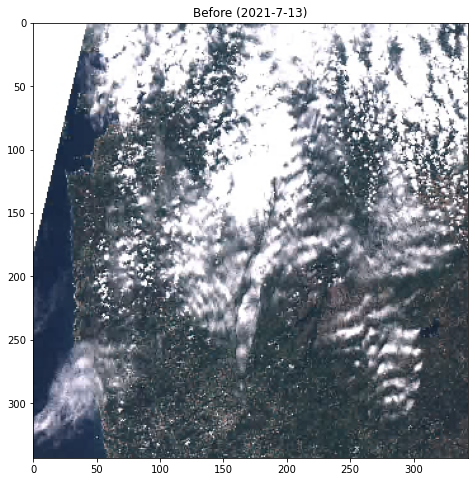

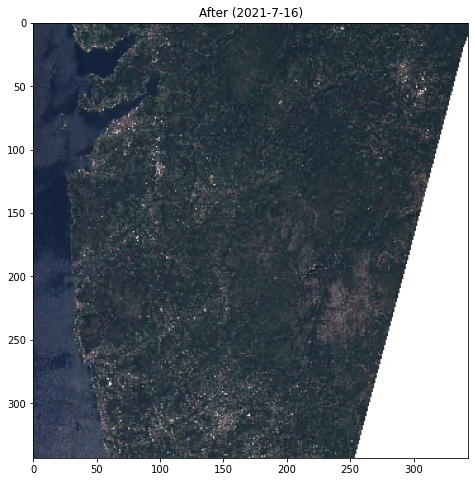

In [ ]:
show_image_before_and_after(FOLDER_BEFORE, FOLDER_AFTER, time_before, time_after, 'preview.jpg')

In [ ]:
def get_bounds(polygon):
    min_lat = 180
    min_lon = 180
    max_lat = -180
    max_lon = -180
    for one in polygon:
        if one[0] < min_lat:
            min_lat = one[0]
        if one[1] < min_lon:
            min_lon = one[1]
        if one[0] > max_lat:
            max_lat = one[0]
        if one[1] > max_lon:
            max_lon = one[1]
            
    return [[min_lat, min_lon], [max_lat, max_lon]]
    

def crop_image_geo(img_path, img_path_dest, bounds_image, bounds_crop, show_image_orig, show_image_cropped):
    # it's not 100% accurate because it doesn't take projection into account, but it's good enough.
    
    # print('bounds_image: ', bounds_image)
    # print('bounds_crop:', bounds_crop)
    
    # Opens a image in RGB mode
    im = Image.open(img_path)

    w, h = im.size
    # print('width: ', w)
    # print('height:', h)
    
    bound_img = get_bounds(bounds_image)
    print(bound_img)
    
    bound_crop = get_bounds(bounds_crop)
    
    crop_top = (bound_img[1][0] - bound_crop[1][0]) * h / (bound_img[1][0] - bound_img[0][0])
    # print(crop_top)
    
    crop_bottom = (bound_crop[0][0] - bound_img[0][0]) * h / (bound_img[1][0] - bound_img[0][0])
    # print(crop_bottom)
       
    crop_left = (bound_crop[0][1] - bound_img[0][1]) * w / (bound_img[1][1] - bound_img[0][1])
    # print(crop_left)
    
    crop_right = (bound_img[1][1] - bound_crop[1][1]) * w / (bound_img[1][1] - bound_img[0][1])
    # print(crop_right)

    # Setting the points for cropped image
    left = crop_left
    top = crop_top
    right = w - crop_right
    bottom = h - crop_bottom

    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((left, top, right, bottom))

    if show_image_orig:
        im.show()
    
    print(bound_crop)
    
    # Shows the image in image viewer
    if show_image_cropped:
        im1.show()
    
    im1.save(img_path_dest + '.crop.png',"PNG")
    
    w, h = im1.size
    print('width: ', w)
    print('height:', h)

[[41.459662384459, -9.0002310646851], [42.452682192651, -7.6663366605707]]


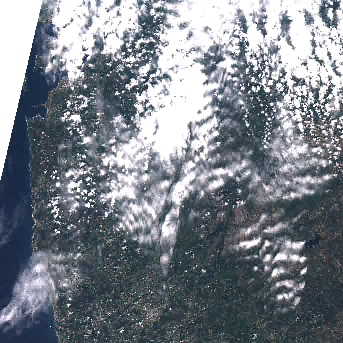

[[41.654400884404204, -8.517099115595801], [41.6633991155958, -8.5081008844042]]


width:  3
height: 3


In [ ]:
crop_image_geo(FOLDER_BEFORE + 'preview.jpg', DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.preview.jpg', bound_tile[:-1], fire_small_perimeter[:-1], True, True)

In [ ]:
crop_image_geo(FOLDER_BEFORE + 'B02.jp2', DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.B02.jp2', bound_tile[:-1], fire_small_perimeter[:-1], False, False)

[[41.459662384459, -9.0002310646851], [42.452682192651, -7.6663366605707]]
[[41.654400884404204, -8.517099115595801], [41.6633991155958, -8.5081008844042]]
width:  74
height: 100


In [ ]:
crop_image_geo(FOLDER_AFTER + 'B02.jp2', FOLDER_AFTER + 'B02.jp2', bound_tile[:-1], fire_small_perimeter[:-1], False, False)

[[41.459662384459, -9.0002310646851], [42.452682192651, -7.6663366605707]]
[[41.654400884404204, -8.517099115595801], [41.6633991155958, -8.5081008844042]]
width:  74
height: 100


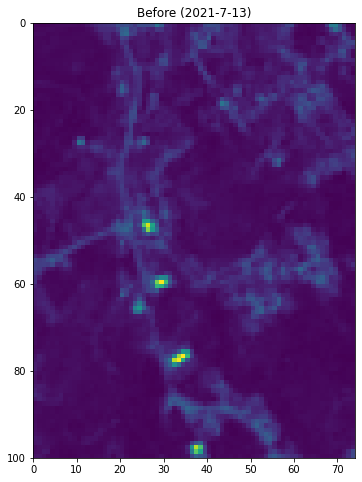

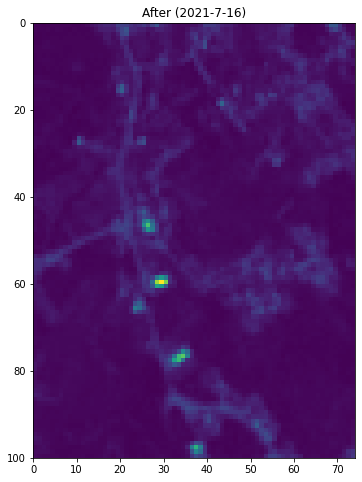

In [ ]:
show_image_before_and_after(DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.', FOLDER_AFTER, time_before, time_after, 'B02.jp2.crop.png')

### 10. Repeat for all wildforests, in order to create cropped images before fire dataset

In [ ]:
df_for_dataset = df_spain_date_filtered[df_spain_date_filtered['type'] == 0]
df_for_dataset

latitude  longitude  brightness  scan  track    acq_date acq_time  \
1702958   35.9118     1.2323       337.2   1.9    1.3  2021-07-01     1239   
1721288   39.3638    -3.8653       334.0   2.1    1.4  2021-07-02     1141   
1724841   35.6441    -0.7811       345.8   1.1    1.0  2021-07-02     1322   
1724842   35.6426    -0.7928       337.0   1.1    1.0  2021-07-02     1322   
1724844   37.6506    -8.5008       345.3   1.5    1.2  2021-07-02     1323   
...           ...        ...         ...   ...    ...         ...      ...   
1970866   41.1895    -7.8678       323.4   3.7    1.8  2021-07-15     0325   
1970867   41.1954    -7.8570       319.8   3.7    1.8  2021-07-15     0325   
1982989   42.1290    -4.4215       322.9   1.9    1.3  2021-07-15     1253   
1987646   41.6589    -8.5126       313.8   1.3    1.1  2021-07-15     2215   
1987647   41.6780    -8.6348       314.8   1.3    1.1  2021-07-15     2215   

        satellite instrument  confidence  version  bright_t31    frp daynight  \
1702958      Aqua      MODIS          77     6.03       314.3   44.9        D   
1721288     Terra      MODIS          77     6.03       313.8   55.3        D   
1724841      Aqua      MODIS          87     6.03       315.6   37.0        D   
1724842      Aqua      MODIS          74     6.03       314.6   21.1        D   
1724844      Aqua      MODIS          89     6.03       308.6   74.2        D   
...           ...        ...         ...      ...         ...    ...      ...   
1970866      Aqua      MODIS         100     6.03       287.2  152.3        N   
1970867      Aqua      MODIS          99     6.03       286.8  129.6        N   
1982989      Aqua      MODIS          73     6.03       306.0   24.4        D   
1987646     Terra      MODIS          88     6.03       294.6   16.8        N   
1987647     Terra      MODIS          90     6.03       294.4   17.9        N   

         type  
1702958     0  
1721288     0  
1724841     0  
1724842     0  
1724844     0  
...       ...  
1970866     0  
1970867     0  
1982989     0  
1987646     0  
1987647     0  

[79 rows x 15 columns]

In [ ]:
def full_process_for_lat_lon(lat_lon, search_time_interval):
    THE_BAND = 'B02'
    
    search_bbox = get_search_bbox(lat_lon)
    print('search_bbox: ' + str(search_bbox))
    
    tile_id_before_fire, tile_id_after_fire, bound_tile = get_data_before_and_after_one_fire(search_bbox, search_time_interval)
    print(tile_id_before_fire)
    print(tile_id_after_fire)
    print('bound_tile: ' + str(bound_tile))
    
    tile_name_before, time_before, aws_index_before = AwsTile.tile_id_to_tile(tile_id_before_fire)
    tile_name_after, time_after, aws_index_after = AwsTile.tile_id_to_tile(tile_id_after_fire)
    
    FOLDER_BEFORE, FOLDER_AFTER = request_tiles(tile_name_before, time_before, aws_index_before, tile_name_after, time_after, aws_index_after)
    
    fire_small_perimeter = swap_lat_lon(search_bbox.get_polygon())
    print('fire_small_perimeter: ' + str(fire_small_perimeter))
    
    bound_tile = swap_lat_lon(bound_tile)
    
    show_image_before_and_after(FOLDER_BEFORE, FOLDER_AFTER, time_before, time_after, 'preview.jpg')
    
    crop_image_geo(FOLDER_BEFORE + 'preview.jpg', DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.preview.jpg', bound_tile[:-1], fire_small_perimeter[:-1], True, True)
    
    crop_image_geo(FOLDER_BEFORE + THE_BAND + '.jp2', DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.' + THE_BAND + '.jp2', bound_tile[:-1], fire_small_perimeter[:-1], False, False)
    crop_image_geo(FOLDER_AFTER + THE_BAND + '.jp2', FOLDER_AFTER + THE_BAND + '.jp2', bound_tile[:-1], fire_small_perimeter[:-1], False, False)
    
    show_image_before_and_after(DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.', FOLDER_AFTER, time_before, time_after, THE_BAND + '.jp2.crop.png')
    
    fullpath_image = DATASET_CROPPED_BEFORE_FIRE_FOLDER + FOLDER_BEFORE.split('/')[-2] + '.' + THE_BAND + '.jp2.crop.png'
    return fullpath_image

selected_row: latitude         35.9118
longitude         1.2323
brightness         337.2
scan                 1.9
track                1.3
acq_date      2021-07-01
acq_time            1239
satellite           Aqua
instrument         MODIS
confidence            77
version             6.03
bright_t31         314.3
frp                 44.9
daynight               D
type                   0
Name: 1702958, dtype: object
2021-07-01
search_time_interval: ('2021-06-16T00:00:00', '2021-07-06T00:00:00')
search_bbox: 1.2278008844041999,35.9073008844042,1.2367991155958,35.9162991155958
3 satellite moments in the interval:

S2A_OPER_MSI_L1C_TL_VGS2_20210701T124711_A031465_T31SCV_N03.01
  [[[[0.7776148911953, 36.124267207564], [0.80484069416807, 35.135011160465], [2.0097096778922, 35.150851996093], [1.9974176909957, 36.140692888429], [0.7776148911953, 36.124267207564]]]]
S2A_OPER_MSI_L1C_TL_VGS2_20210621T142009_A031322_T31SCV_N03.00
  [[[[0.7776148911953, 36.124267207564], [0.80484069416807, 35.13501

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.00 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)


FOLDER_BEFORE: ./AwsData/31SCV,2021-06-16,1/


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.01 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


FOLDER_AFTER: ./AwsData/31SCV,2021-07-01,0/
fire_small_perimeter: [[35.9073008844042, 1.2278008844041999], [35.9162991155958, 1.2278008844041999], [35.9162991155958, 1.2367991155958], [35.9073008844042, 1.2367991155958], [35.9073008844042, 1.2278008844041999]]


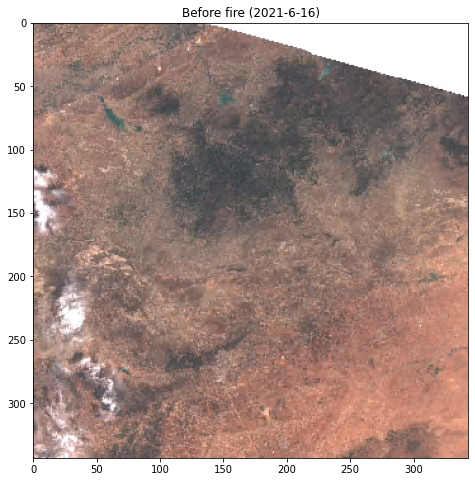

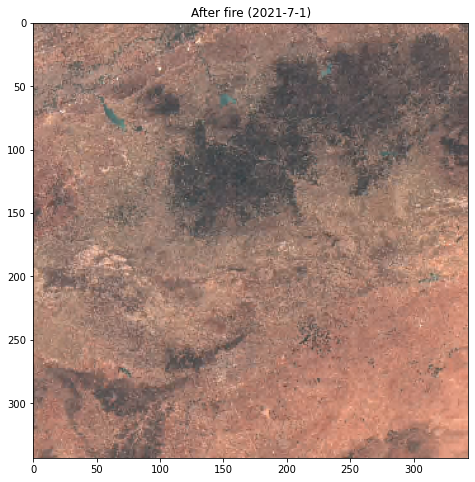

[[35.135011160465, 0.7776148911953], [36.140692888429, 2.0097096778922]]


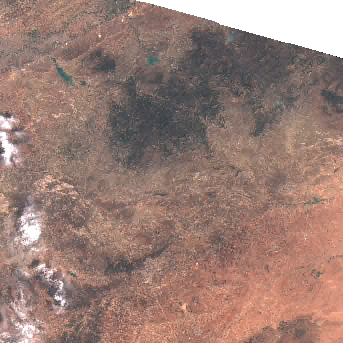

[[35.9073008844042, 1.2278008844041999], [35.9162991155958, 1.2367991155958]]


width:  3
height: 3
[[35.135011160465, 0.7776148911953], [36.140692888429, 2.0097096778922]]
[[35.9073008844042, 1.2278008844041999], [35.9162991155958, 1.2367991155958]]
width:  80
height: 98
[[35.135011160465, 0.7776148911953], [36.140692888429, 2.0097096778922]]
[[35.9073008844042, 1.2278008844041999], [35.9162991155958, 1.2367991155958]]
width:  80
height: 98


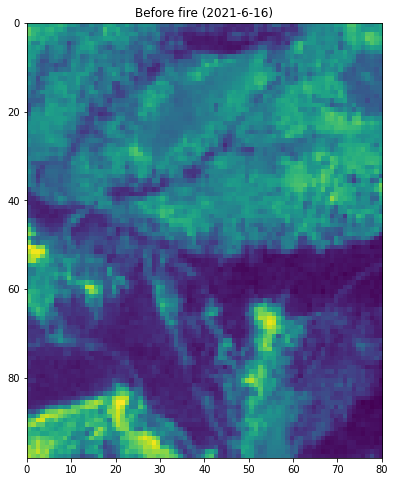

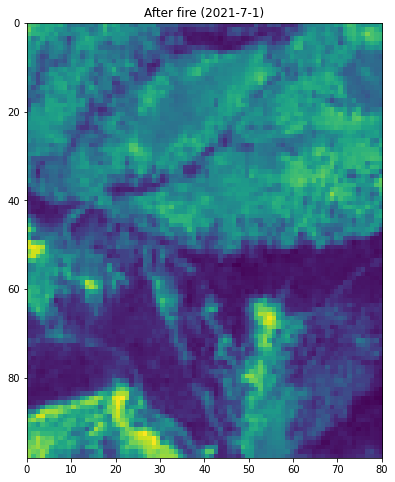

selected_row: latitude         39.3638
longitude        -3.8653
brightness         334.0
scan                 2.1
track                1.4
acq_date      2021-07-02
acq_time            1141
satellite          Terra
instrument         MODIS
confidence            77
version             6.03
bright_t31         313.8
frp                 55.3
daynight               D
type                   0
Name: 1721288, dtype: object
2021-07-02
search_time_interval: ('2021-06-17T00:00:00', '2021-07-07T00:00:00')
search_bbox: -3.8697991155958,39.3593008844042,-3.8608008844042,39.368299115595796
6 satellite moments in the interval:

S2B_OPER_MSI_L1C_TL_VGS2_20210705T131926_A022614_T30SVJ_N03.01
  [[[[-4.1676129061651, 39.744386309942], [-4.1513211203196, 38.755202927617], [-3.9639359251734, 38.756898608041], [-3.6172971017433, 39.748617549456], [-4.1676129061651, 39.744386309942]]]]
S2B_OPER_MSI_L1C_TL_VGS4_20210702T121603_A022571_T30SVJ_N03.01
  [[[[-4.1676129061651, 39.744386309942], [-4.1513211203196, 38

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.01 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)


FOLDER_AFTER: ./AwsData/30SVJ,2021-07-05,0/
fire_small_perimeter: [[39.3593008844042, -3.8697991155958], [39.368299115595796, -3.8697991155958], [39.368299115595796, -3.8608008844042], [39.3593008844042, -3.8608008844042], [39.3593008844042, -3.8697991155958]]


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


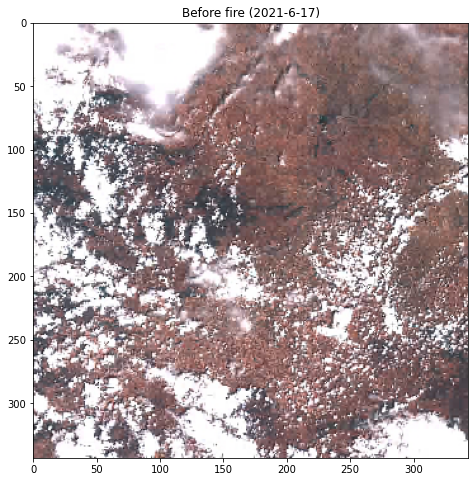

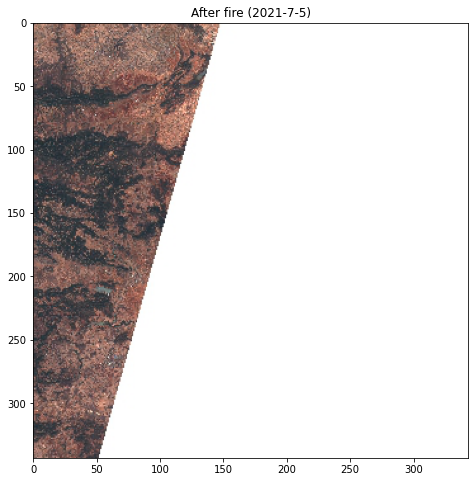

[[38.755202927617, -4.1676129061651], [39.748617549456, -3.6172971017433]]


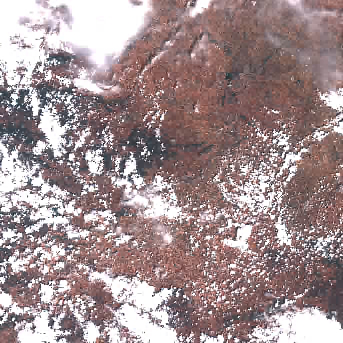

[[39.3593008844042, -3.8697991155958], [39.368299115595796, -3.8608008844042]]


width:  5
height: 3
[[38.755202927617, -4.1676129061651], [39.748617549456, -3.6172971017433]]
[[39.3593008844042, -3.8697991155958], [39.368299115595796, -3.8608008844042]]
width:  180
height: 99
[[38.755202927617, -4.1676129061651], [39.748617549456, -3.6172971017433]]
[[39.3593008844042, -3.8697991155958], [39.368299115595796, -3.8608008844042]]
width:  180
height: 99


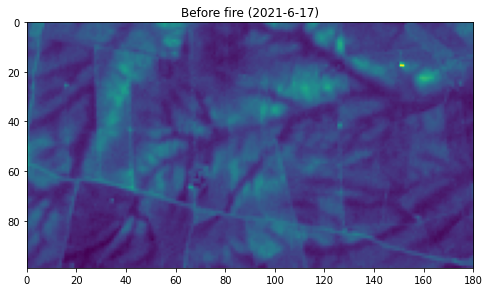

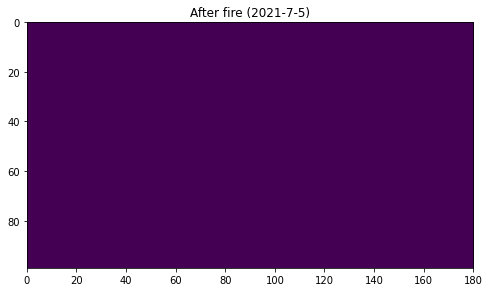

selected_row: latitude         35.6441
longitude        -0.7811
brightness         345.8
scan                 1.1
track                1.0
acq_date      2021-07-02
acq_time            1322
satellite           Aqua
instrument         MODIS
confidence            87
version             6.03
bright_t31         315.6
frp                 37.0
daynight               D
type                   0
Name: 1724841, dtype: object
2021-07-02
search_time_interval: ('2021-06-17T00:00:00', '2021-07-07T00:00:00')
search_bbox: -0.7855991155958,35.6396008844042,-0.7766008844042,35.6485991155958
10 satellite moments in the interval:

S2B_OPER_MSI_L1C_TL_VGS2_20210706T124446_A022628_T30SXE_N03.01
  [[[[-0.67032866903553, 36.07034215404], [-0.92677268966951, 35.137159415944], [-0.69735281052744, 35.133015549128], [-0.67032866903553, 36.07034215404]]]]
S2B_OPER_MSI_L1C_TL_VGS2_20210706T124446_A022628_T30SYE_N03.01
  [[[[-0.65609673129626, 36.121949984616], [-0.79178544928712, 35.630670292374], [-0.80525750431997

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.00 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)


FOLDER_BEFORE: ./AwsData/30SXE,2021-06-24,0/


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 03.01 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)


FOLDER_AFTER: ./AwsData/30SXE,2021-07-06,0/
fire_small_perimeter: [[35.6396008844042, -0.7855991155958], [35.6485991155958, -0.7855991155958], [35.6485991155958, -0.7766008844042], [35.6396008844042, -0.7766008844042], [35.6396008844042, -0.7855991155958]]


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


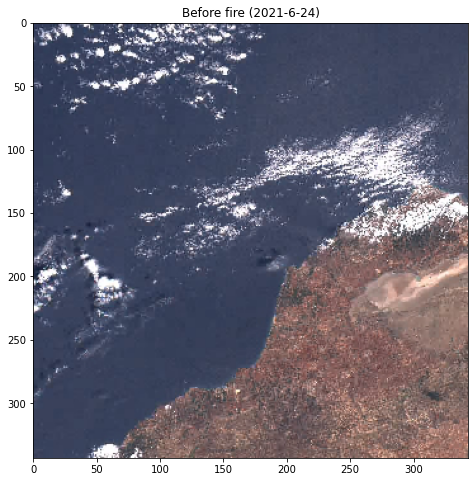

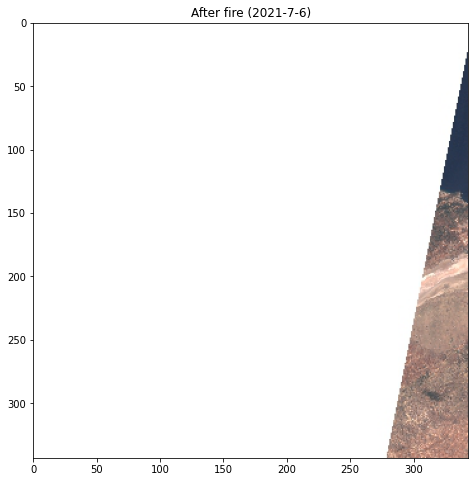

[[35.133015549128, -0.92677268966951], [36.07034215404, -0.67032866903553]]


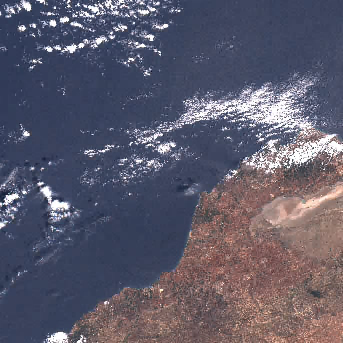

[[35.6396008844042, -0.7855991155958], [35.6485991155958, -0.7766008844042]]


width:  12
height: 4
[[35.133015549128, -0.92677268966951], [36.07034215404, -0.67032866903553]]
[[35.6396008844042, -0.7855991155958], [35.6485991155958, -0.7766008844042]]
width:  385
height: 106
[[35.133015549128, -0.92677268966951], [36.07034215404, -0.67032866903553]]
[[35.6396008844042, -0.7855991155958], [35.6485991155958, -0.7766008844042]]
width:  385
height: 106


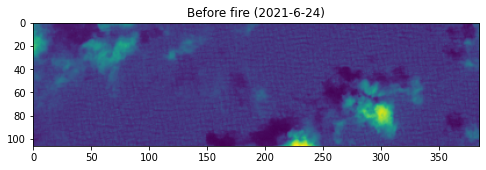

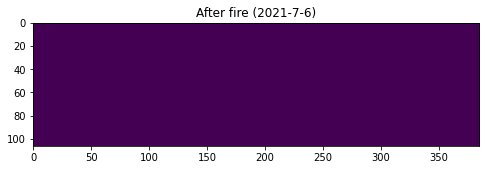

In [ ]:
LOOP_LIMIT = 3 # edit this line
i = 0

for index, row in df_for_dataset.iterrows(): # for i in [1721288, 1702958, 1721288, 1724841, 1987646]:       
    row_selected = row # df_orig.iloc[i]
    print('selected_row: ' + str(row_selected))
    
    search_time_interval, lat_lon = get_search_time_interval_and_lat_lon(row_selected)

    full_process_for_lat_lon(lat_lon, search_time_interval)
    
    i += 1
    if i == LOOP_LIMIT:
        break

In [ ]:
print('Done :)')

Done :)


In [ ]:
!tar -czf dataset_before_fire.tar.gz dataset_before_fire

### 10. Off Topic: Normalized Difference Vegetation Index - NVDI

In [ ]:
def show_ndvi(folder, title):
    b4 = rasterio.open(folder + 'B04.jp2')
    b8 = rasterio.open(folder + 'B08.jp2')

    # read Red(b4) and NIR(b8) as arrays
    red = b4.read()
    nir = b8.read()
    ndvi = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

    title_full = title + ". Normalized Difference Vegetation Index (NDVI)"
    ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=title_full, vmin=-1, vmax=1);
    

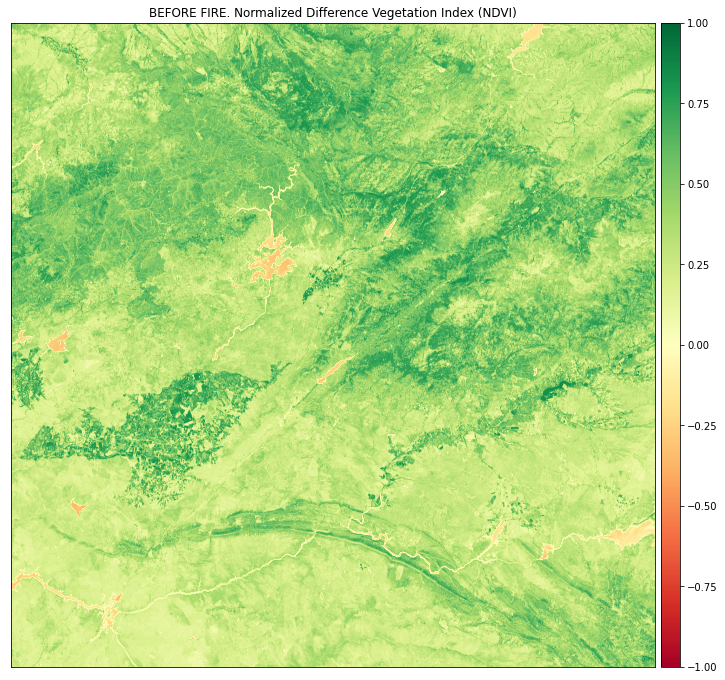

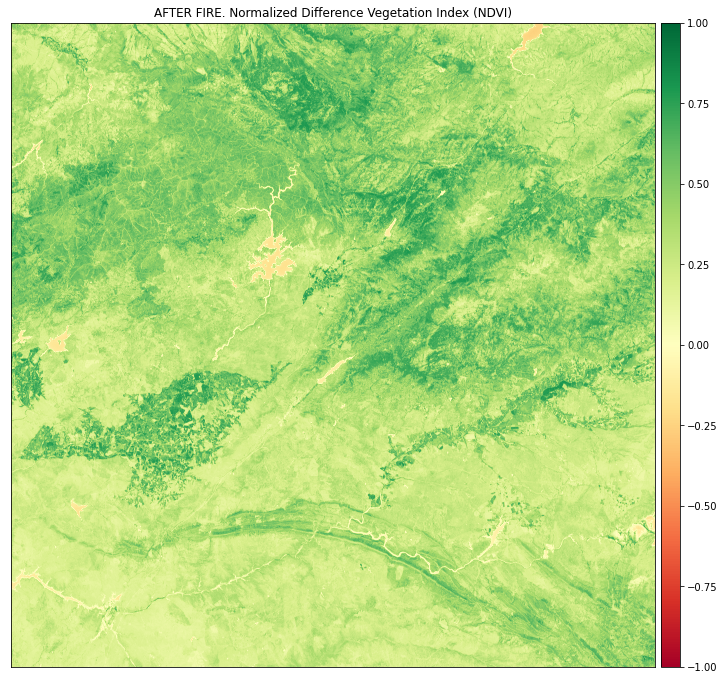

In [ ]:
show_ndvi(FOLDER_BEFORE, 'BEFORE FIRE')
show_ndvi(FOLDER_AFTER, 'AFTER FIRE')

### 11. Convert from mono Band to RGB.

In [ ]:
def convert_from_one_band_to_gray(pathfile):
    new_file_aux = 'temp.tiff'

    band2=rasterio.open(pathfile)

    band2_geo = band2.profile
    band2_geo.update({"count": 3})

    with rasterio.open(new_file_aux, 'w', **band2_geo) as dest:
        dest.write(band2.read(1),1)
        dest.write(band2.read(1),2)
        dest.write(band2.read(1),3)

    rgb_image = rasterio.open(new_file_aux)

    max_pixel_value = rgb_image.read().max()
    rgb_image = np.multiply(rgb_image.read(), 255.0)
    rgb_image = np.divide(rgb_image, max_pixel_value)
    rgb_image = rgb_image.astype(np.uint8)
    
    rgb_image.astype(np.uint8)

    # print('rgb_image shape: ' + str(rgb_image.shape))
    # print(str(rgb_image))
    # plot.show(rgb_image)
    
    im = Image.fromarray(rgb_image[0])
    
    return im

In [ ]:
if not os.path.exists('dataset_before_fire_gray'):
    os.makedirs('dataset_before_fire_gray')

In [ ]:
train_fire_list_png = glob.glob(os.path.join('./dataset_before_fire','*.jp2.crop.png'))
train_fire_list_png

['./dataset_before_fire/29SNB,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire/30SXJ,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire/30TVK,2021-06-27,0.B02.jp2.crop.png',
 './dataset_before_fire/29SQC,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire/31TEH,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire/30SUH,2021-06-27,0.B02.jp2.crop.png',
 './dataset_before_fire/29SPD,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire/31SDA,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire/30TTM,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire/31TCG,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire/30TXL,2022-01-30,0.B02.jp2.crop.png',
 './dataset_before_fire/29TNG,2021-07-13,0.B02.jp2.crop.png']

In [ ]:
# x = convert_from_one_band_to_gray('./dataset_before_fire/29TNG,2021-07-13,0.B02.jp2.crop.png')
# x.save('borrar.png')

In [ ]:
for one in train_fire_list_png:
    im = convert_from_one_band_to_gray(one)
    im.save('./dataset_before_fire_gray/' + one.split('/')[-1])
print('Converted :)')

Converted :)


### 12. Visual Transformer. Classification between potential place for future fire and no future fire.

In [ ]:
%pip -q install vit_pytorch linformer

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from __future__ import print_function

from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.2+cu102


In [ ]:
# Training settings
batch_size = 8 # 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = 'cuda'

In [ ]:
%pwd

'/home/studio-lab-user'

In [ ]:
train_fire_list_png_gray = glob.glob(os.path.join('./dataset_before_fire_gray/','*.jp2.crop.png'))
train_fire_list_png_gray

['./dataset_before_fire_gray/fire.30SXJ,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SXE,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SQC,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31SDA,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TXL,2022-01-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29TNG,2021-07-13,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TVK,2021-06-27,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SPD,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31TCG,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SVJ,2021-06-17,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SNB,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31TEH,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TTM,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SUH,2021-06-27,0.B02.jp2.cro

In [ ]:
for one in train_fire_list_png_gray:
    if os.path.basename(one).startswith('fire.') == False:
        os.rename(one, './dataset_before_fire_gray/' + 'fire.' + os.path.basename(one))

In [ ]:
train_fire_list_png_gray = glob.glob(os.path.join('./dataset_before_fire_gray/','*.jp2.crop.png'))
train_fire_list_png_gray

['./dataset_before_fire_gray/fire.30SXJ,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SXE,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SQC,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31SDA,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TXL,2022-01-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29TNG,2021-07-13,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TVK,2021-06-27,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SPD,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31TCG,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SVJ,2021-06-17,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SNB,2021-06-23,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31TEH,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TTM,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SUH,2021-06-27,0.B02.jp2.cro

In [ ]:
train_no_fire = glob.glob(os.path.join('./dataset_no_fire','*.jpg'))
train_no_fire

['./dataset_no_fire/no.10872.jpg',
 './dataset_no_fire/no.10869.jpg',
 './dataset_no_fire/no.10875.jpg',
 './dataset_no_fire/no.10882.jpg',
 './dataset_no_fire/no.10886.jpg',
 './dataset_no_fire/no.10893.jpg',
 './dataset_no_fire/no.10903.jpg',
 './dataset_no_fire/no.10894.jpg',
 './dataset_no_fire/no.109.jpg',
 './dataset_no_fire/no.10898.jpg',
 './dataset_no_fire/no.10896.jpg']

In [ ]:
if not os.path.exists('dataset_no_fire_gray'):
    os.makedirs('dataset_no_fire_gray')
    
for one in train_no_fire:
    x = convert_from_one_band_to_gray(one)
    x.save('./dataset_no_fire_gray/' + os.path.basename(one))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  s = writer(path, mode, driver=driver,


In [ ]:
train_no_fire_gray = glob.glob(os.path.join('./dataset_no_fire_gray','*.jpg'))
train_no_fire_gray

['./dataset_no_fire_gray/no.10872.jpg',
 './dataset_no_fire_gray/no.10869.jpg',
 './dataset_no_fire_gray/no.10875.jpg',
 './dataset_no_fire_gray/no.10882.jpg',
 './dataset_no_fire_gray/no.10886.jpg',
 './dataset_no_fire_gray/no.10893.jpg',
 './dataset_no_fire_gray/no.10903.jpg',
 './dataset_no_fire_gray/no.10894.jpg',
 './dataset_no_fire_gray/no.109.jpg',
 './dataset_no_fire_gray/no.10898.jpg',
 './dataset_no_fire_gray/no.10896.jpg']

In [ ]:
train_list = train_no_fire_gray + train_fire_list_png_gray
train_list

['./dataset_no_fire_gray/no.10872.jpg',
 './dataset_no_fire_gray/no.10869.jpg',
 './dataset_no_fire_gray/no.10875.jpg',
 './dataset_no_fire_gray/no.10882.jpg',
 './dataset_no_fire_gray/no.10886.jpg',
 './dataset_no_fire_gray/no.10893.jpg',
 './dataset_no_fire_gray/no.10903.jpg',
 './dataset_no_fire_gray/no.10894.jpg',
 './dataset_no_fire_gray/no.109.jpg',
 './dataset_no_fire_gray/no.10898.jpg',
 './dataset_no_fire_gray/no.10896.jpg',
 './dataset_before_fire_gray/fire.30SXJ,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30SXE,2021-06-24,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SQC,2021-06-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.31SDA,2021-06-21,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TXL,2022-01-30,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29TNG,2021-07-13,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.30TVK,2021-06-27,0.B02.jp2.crop.png',
 './dataset_before_fire_gray/fire.29SPD,2021-06-23,0.B02.j

In [ ]:
random.shuffle(train_list)

In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
labels

['fire',
 'fire',
 'no',
 'fire',
 'fire',
 'no',
 'no',
 'no',
 'fire',
 'fire',
 'fire',
 'fire',
 'no',
 'fire',
 'fire',
 'fire',
 'no',
 'fire',
 'fire',
 'no',
 'fire',
 'no',
 'no',
 'no',
 'no',
 'fire']

In [ ]:
len(train_list)

26

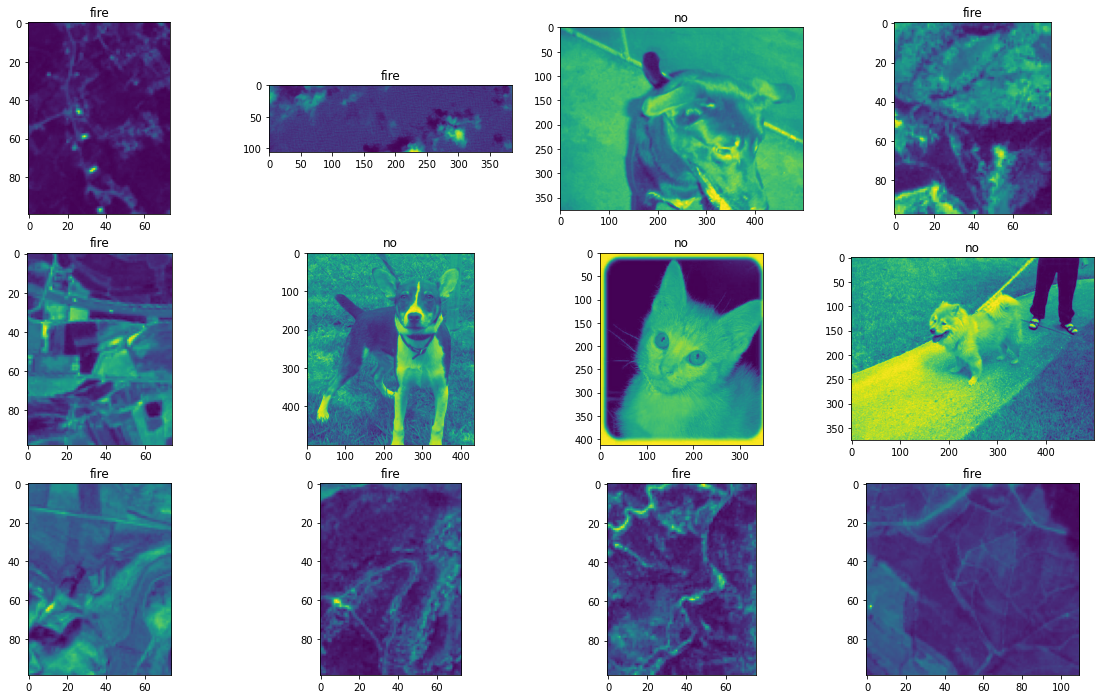

In [ ]:
random_idx = np.random.randint(1, len(train_list))
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
# print(f"Test Data: {len(test_list)}")

Train Data: 20
Validation Data: 6


In [ ]:
# image augmentation:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [ ]:
# load dataset:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "fire" else 0

        return img_transformed, label

In [ ]:
label_strings = {}
label_strings[0] = 'no fire ✅'
label_strings[1] = 'potential future fire 🔥'

color_prediction = {}
color_prediction[0] = 'green'
color_prediction[1] = 'red'

In [ ]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
# test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

20 3


In [ ]:
print(len(valid_data), len(valid_loader))

6 1


In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=1, # FIXED! Channels=1 (grayscale)
).to(device)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            print('shape data: ' + str(data.shape))
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 1 - loss : 0.6926 - acc: 0.5833 - val_loss : 0.6968 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 2 - loss : 0.7024 - acc: 0.4167 - val_loss : 0.6933 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 3 - loss : 0.6960 - acc: 0.4167 - val_loss : 0.6962 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 4 - loss : 0.6654 - acc: 0.6250 - val_loss : 0.7142 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 5 - loss : 0.6658 - acc: 0.6250 - val_loss : 0.7470 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 6 - loss : 0.6641 - acc: 0.6250 - val_loss : 0.7559 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 7 - loss : 0.6971 - acc: 0.5833 - val_loss : 0.7512 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 8 - loss : 0.6785 - acc: 0.6250 - val_loss : 0.7244 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 9 - loss : 0.6652 - acc: 0.6250 - val_loss : 0.7142 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 10 - loss : 0.6644 - acc: 0.6250 - val_loss : 0.7141 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 11 - loss : 0.7039 - acc: 0.5417 - val_loss : 0.7166 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 12 - loss : 0.6568 - acc: 0.6667 - val_loss : 0.7073 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 13 - loss : 0.6637 - acc: 0.6250 - val_loss : 0.7103 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 14 - loss : 0.6615 - acc: 0.6250 - val_loss : 0.7186 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 15 - loss : 0.6823 - acc: 0.5833 - val_loss : 0.7275 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 16 - loss : 0.7121 - acc: 0.5417 - val_loss : 0.7284 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 17 - loss : 0.6694 - acc: 0.6250 - val_loss : 0.7120 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 18 - loss : 0.6663 - acc: 0.6250 - val_loss : 0.7071 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 19 - loss : 0.6523 - acc: 0.6667 - val_loss : 0.7094 - val_acc: 0.5000



  0%|          | 0/3 [00:00<?, ?it/s]

shape data: torch.Size([6, 1, 224, 224])
Epoch : 20 - loss : 0.6602 - acc: 0.6250 - val_loss : 0.7190 - val_acc: 0.5000



### 13. Predictions using trained Visual Transformer, from URL image.

In [ ]:
def prepare_data_for_model_from_image_path(imgPath):
    TEMP_PATH = './temp.png'
    
    gray_img = convert_from_one_band_to_gray(imgPath)
    gray_img.save(TEMP_PATH)
    
    dataset = CatsDogsDataset([TEMP_PATH], transform=test_transforms)

    data = dataset[0][0]
    print('prev data shape: ' + str(data.shape))

    data = data[None, :] # batch 1.
    # print(str(img.shape))
    data = data.to(device)
    print('data shape: ' + str(data.shape))
    
    return data


def get_label_message_from_prediction(preds):
    i = torch.argmax(preds)
    i = i.item()
    labelWidget  = HTML(value = f"<h2><b><font color='" + color_prediction[i] + "'>" + label_strings[i] + "</b></h2>")
    display(labelWidget)

In [ ]:
imgPath = './dataset_before_fire_gray/fire.31TCG,2021-06-24,0.B02.jp2.crop.png'

data = prepare_data_for_model_from_image_path(imgPath)

preds = model(data)
print('preds: ' +  str(preds))

get_label_message_from_prediction(preds)

prev data shape: torch.Size([1, 224, 224])
data shape: torch.Size([1, 1, 224, 224])
preds: tensor([[-0.2553,  0.2093]], device='cuda:0', grad_fn=<AddmmBackward0>)


HTML(value="<h2><b><font color='red'>potential future fire 🔥</b></h2>")

### 14. Predictions using trained Visual Transformer, from File Upload.

In [ ]:
uploader = FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
uploaded_file = list(uploader.value.values())[0]
with open("./temp.png", "wb") as fp:
    fp.write(uploaded_file['content'])
    
imgWidget = ImageWidget(value=uploaded_file['content'])
display(imgWidget)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xac\x00\x00\x03\x13\x08\x02\x00\x00\x00[\x92\xa1…

In [ ]:
data = prepare_data_for_model_from_image_path("./temp.png")

preds = model(data)

get_label_message_from_prediction(preds)

prev data shape: torch.Size([1, 224, 224])
data shape: torch.Size([1, 1, 224, 224])


HTML(value="<h2><b><font color='red'>potential future fire 🔥</b></h2>")

### 15. Predictions using trained Visual Transformer, from Click on Map to get Lat/lon.

In [ ]:
m

Map(bottom=24785.0, center=[41.56203190200195, -7.75417636591683], controls=(ZoomControl(options=['position', …

In [ ]:
global lastLatLonClicked
lastLatLonClicked

[40.33921721760713, -6.327524185180664]

In [ ]:
def predict_from_lat_lon_for_now(model, lastLatLonClicked):
    now = datetime.date.today()

    datetime_from = now - datetime.timedelta(days=15) # -15 days before fire.
    datetime_from_str = datetime_from.strftime("%Y-%m-%d") + 'T00:00:00'

    datetime_to_str = now.strftime("%Y-%m-%d") + 'T00:00:00'

    search_time_interval = (datetime_from_str, datetime_to_str)
    print('search_time_interval: ' + str(search_time_interval))
    
    fullpath_image_cropped = full_process_for_lat_lon(lastLatLonClicked, search_time_interval)
    print('image cropped from clicked area: ' + fullpath_image_cropped)
    
    data = prepare_data_for_model_from_image_path(fullpath_image_cropped)

    preds = model(data)
    predictedIndex = torch.argmax(preds)
    prediction = label_strings[predictedIndex.item()]
    return prediction

search_time_interval: ('2022-02-04T00:00:00', '2022-02-19T00:00:00')
search_bbox: -6.332023300776464,40.33471810201133,-6.323025069584864,40.34371633320293
10 satellite moments in the interval:

S2A_OPER_MSI_L1C_TL_VGS2_20220218T151306_A034783_T29TQE_N04.00
  [[[[-6.6357802685921, 40.626640163345], [-6.6697722895536, 39.639136646243], [-6.1712427484996, 39.628238982886], [-5.9924150562353, 40.137297235942], [-5.8222466024961, 40.607106404614], [-6.6357802685921, 40.626640163345]]]]
S2A_OPER_MSI_L1C_TL_VGS2_20220218T151306_A034783_T30TTK_N04.00
  [[[[-6.5454514550479, 40.596392838306], [-6.4945467653338, 39.609921873217], [-6.174243355979, 39.619663177547], [-5.992282322749, 40.137663238247], [-5.8187638168555, 40.616433952333], [-6.5454514550479, 40.596392838306]]]]
S2A_OPER_MSI_L1C_TL_VGS2_20220215T150628_A034740_T29TQE_N04.00
  [[[[-6.6357802685921, 40.626640163345], [-6.6698025177, 39.638236352213], [-5.392258773537, 39.605556990167], [-5.3396665613559, 40.592804804321], [-6.6357802

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 04.00 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/download/client.py:103: SHRuntimeWarning: File in location s3://sentinel-s2-l1c/tiles/29/T/QE/2022/2/5/0/qi/MSK_CLOUDS_B00.gml is missing
  warnings.warn(str(download_exception), category=SHRuntimeWarning)


FOLDER_BEFORE: ./AwsData/29TQE,2022-02-05,0/


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/aws.py:167: SHUserWarning: Products with baseline 04.00 are not officially supported in sentinelhub-py. If you notice any errors in naming structure of downloaded data please report an issue at https://github.com/sentinel-hub/sentinelhub-py/issues. Pull requests are also very appreciated
  warnings.warn(message, category=SHUserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sentinelhub/download/client.py:103: SHRuntimeWarning: File in location s3://sentinel-s2-l1c/tiles/29/T/QE/2022/2/18/0/qi/MSK_CLOUDS_B00.gml is missing
  warnings.warn(str(download_exception), category=SHRuntimeWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


FOLDER_AFTER: ./AwsData/29TQE,2022-02-18,0/
fire_small_perimeter: [[40.33471810201133, -6.332023300776464], [40.34371633320293, -6.332023300776464], [40.34371633320293, -6.323025069584864], [40.33471810201133, -6.323025069584864], [40.33471810201133, -6.332023300776464]]


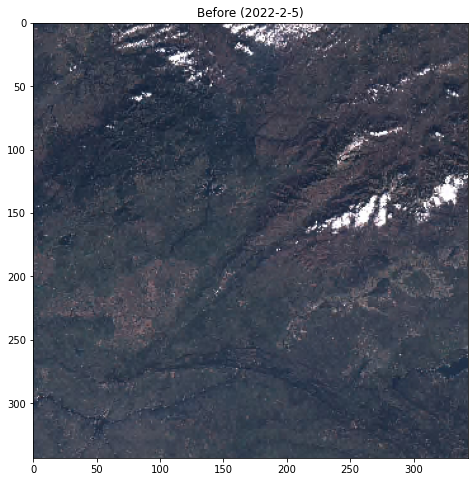

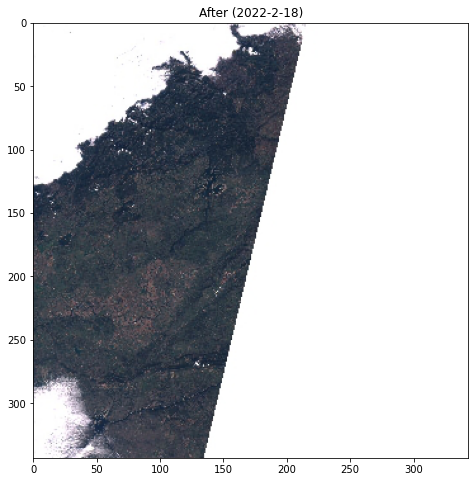

[[39.628238982886, -6.6697722895536], [40.626640163345, -5.8222466024961]]


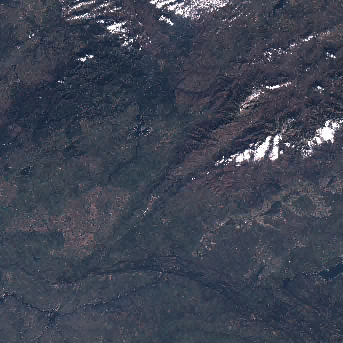

[[40.33471810201133, -6.332023300776464], [40.34371633320293, -6.323025069584864]]


width:  3
height: 3
[[39.628238982886, -6.6697722895536], [40.626640163345, -5.8222466024961]]
[[40.33471810201133, -6.332023300776464], [40.34371633320293, -6.323025069584864]]
width:  116
height: 99
[[39.628238982886, -6.6697722895536], [40.626640163345, -5.8222466024961]]
[[40.33471810201133, -6.332023300776464], [40.34371633320293, -6.323025069584864]]
width:  116
height: 99


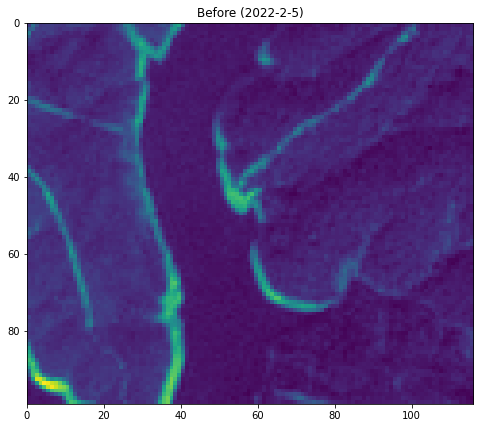

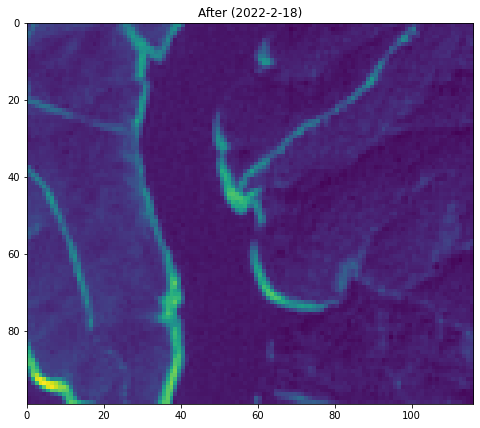

image cropped from clicked area: ./dataset_before_fire/29TQE,2022-02-05,0.B02.jp2.crop.png
prev data shape: torch.Size([1, 224, 224])
data shape: torch.Size([1, 1, 224, 224])


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  s = writer(path, mode, driver=driver,


'potential future fire 🔥'

In [ ]:
predict_from_lat_lon_for_now(model, lastLatLonClicked)

In [ ]:
print('The end :)')

The end :)
